In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 4)

prices = pd.read_excel('data/prices/prices.xlsx', header=0, index_col=0)
prices = prices.drop([2018, 2019], axis=1)

prices_may = pd.read_excel('data/prices/prices_end_may.xlsx', header=0, index_col=0)
prices_may = prices_may.drop([2018, 2019], axis=1)

display(prices.head())

,Category,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Château Lafite Rothschild,Premier cru 1855,671.0,1133.0,284.0,2666.0,574.0,668.0,432.0,618.0,310.0,...,595,694,712,498,511.0,485.0,563.0,584.0,835.0,516.0
Château Latour,Premier cru 1855,445.0,442.0,328.0,442.0,860.0,658.0,525.0,466.0,418.0,...,479,941,1229,495,NaN,NaN,NaN,NaN,NaN,NaN
Château Mouton Rothschild,Premier cru 1855,982.0,1013.0,439.0,817.0,1842.0,1082.0,688.0,539.0,676.0,...,434,712,709,430,472.0,376.0,409.0,552.0,611.0,NaN
Château Margaux,Premier cru 1855,316.0,NaN,328.0,997.0,645.0,514.0,361.0,259.0,364.0,...,368,634,625,384,404.0,389.0,409.0,1228.0,566.0,347.0
Château Haut-Brion,Premier cru 1855,510.0,883.0,368.0,837.0,685.0,1005.0,286.0,424.0,282.0,...,356,663,710,368,327.0,337.0,340.0,556.0,583.0,NaN


- ## End of prices: 2017

# Exploring data

## Selecting our wine sample

So far, I've considered only the 1855 Premiers crus (First Growth). But I want to include other wines to have a more consistent sample. Where to get them? I have a sample of Saint-Emilion Premiers Crus and 1855 seconds crus.
I will rank them based on their price, for vintages later than 1980.

Avg absolute relative price diff 0.035
['Le Pin', 'Château Lafleur', 'Château Lafite Rothschild', 'Château Latour', 'Château Mouton Rothschild', 'Château Cheval Blanc', 'Château Haut-Brion', 'Château Ausone', 'Château Margaux', 'Château Palmer', 'Château Trotte Vieille', 'Château Angélus', 'Petrus', 'Château Pavie', 'Château Léoville Las Cases', 'Château Pichon-Longueville Comtesse de Lalande', 'Château Figeac', 'Château Montrose', 'Château Ducru-Beaucaillou', 'Château Pichon-Longueville Baron', 'Château Léoville Barton', 'Chateau Beausejour Duffau-Lagarrosse', 'Château Gruaud Larose', 'Château Léoville Poyferré', 'Château Rauzan-Ségla', 'Château Canon', 'Clos Fourtet', 'Château Magdelaine', 'Château Belair-Monange', 'Château la Gaffeliere-Naudes']


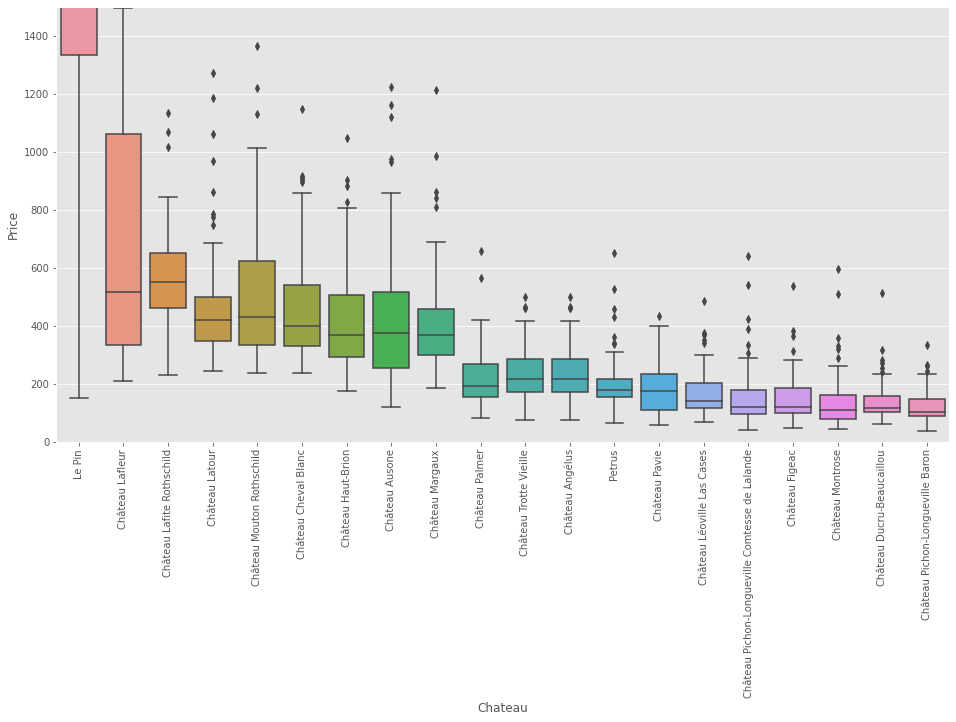

In [103]:
df_dec = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df_dec = df_dec.replace(-100, np.NaN)

df_may = prices_may.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df_may = df_may.replace(-100, np.NaN)


#Combine both databases
df = df_dec
df['Price dec'] = df_dec['Price']
df['Price may'] = df_may['Price']
df['Price'] = df.apply(
    lambda row: row['Price may'] if (pd.isnull(row['Price dec']) and not pd.isnull(row['Price may']))
        else (row['Price dec'] if (not pd.isnull(row['Price dec']) and pd.isnull(row['Price may']))
                 else (row['Price dec'] + row['Price may'])/2)
    , axis=1
)

df['Log Price'] = np.log(df['Price'])


df['Price diff'] = df_may['Price'] - df_dec['Price']
df['Relative price diff'] = df['Price diff'] / df['Price']
df['Abs relative price diff'] = np.abs(df['Relative price diff'])

print('Avg absolute relative price diff', round(np.mean(df['Abs relative price diff']), 3))


ranking = df.groupby('Chateau')['Price'].mean().sort_values(ascending=False)
top_wines = ranking.index.to_list()[:30]
print(top_wines)

##Display prices differences for top wines
#plt.figure(figsize=(16, 8))
#sns.lineplot(data=df_may[df_may['Chateau'] == 'Château Latour'], x='Vintage', y='Price', hue='Chateau')
#plt.xticks(rotation=90)
#plt.show()




#Display boxplots of top wines from both rankings

plt.figure(figsize=(16, 8))
sns.boxplot(data=df[(df_dec['Chateau'].isin(top_wines[:20]))], x='Chateau', y='Price', order = top_wines[:20])
plt.xticks(rotation=90)
plt.ylim(0,1500)
plt.savefig('views/top_wines.png', bbox_inches='tight')
plt.show()



In [104]:
top_wines.remove('Le Pin')
top_wines.remove('Château Lafleur')
top_wines.remove('Château Haut-Brion')

In [105]:
top_wines = top_wines[:14]
print(top_wines)


medoc_wines = ['Château Lafite Rothschild', 'Château Mouton Rothschild', 'Château Latour', 'Château Margaux', 'Château Palmer', 'Château Léoville Las Cases', 'Château Pichon-Longueville Comtesse de Lalande']
st_em_wines = ['Château Cheval Blanc', 'Château Ausone','Château Angélus', 'Château Trotte Vieille','Château Pavie', 'Petrus', 'Château Figeac']

['Château Lafite Rothschild', 'Château Latour', 'Château Mouton Rothschild', 'Château Cheval Blanc', 'Château Ausone', 'Château Margaux', 'Château Palmer', 'Château Trotte Vieille', 'Château Angélus', 'Petrus', 'Château Pavie', 'Château Léoville Las Cases', 'Château Pichon-Longueville Comtesse de Lalande', 'Château Figeac']


### Mapping top vineyards

In [106]:
locations = {
    'Château Lafite Rothschild': [ 45.225, -0.772],
    'Château Latour': [ 45.176, -0.745],
    'Château Mouton Rothschild': [ 45.213, -0.770],
    'Château Cheval Blanc': [ 44.919, -0.189],
    'Château Ausone': [ 44.889, -0.157],
    'Château Margaux': [ 45.044, -0.669],
    'Château Palmer': [ 45.036, -0.669],
    'Château Trotte Vieille': [ 44.894, -0.145],
    'Château Angélus': [ 44.893, -0.172],
    'Petrus': [ 44.931, -0.193],
    'Château Pavie': [ 44.883, -0.151],
    'Château Léoville Las Cases': [ 45.164, -0.740],
    'Château Pichon-Longueville Comtesse de Lalande': [ 45.176, -0.750],
    'Château Figeac':[44.913, -0.192]
}

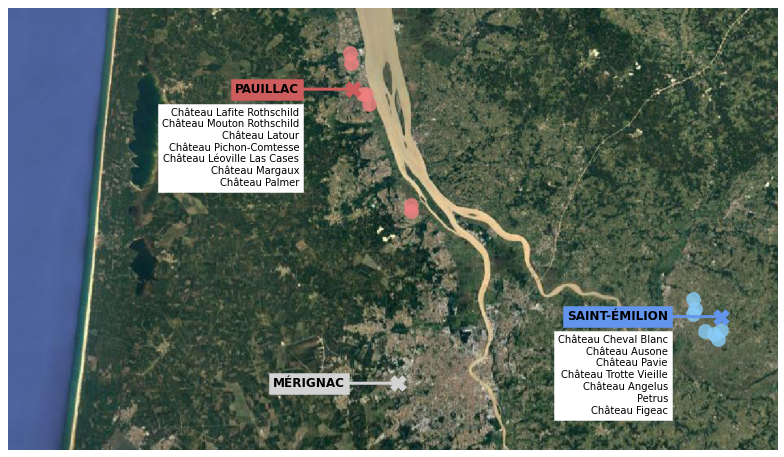

In [127]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

figure, ax = plt.subplots(1,1,figsize = (11,7),subplot_kw = {'projection': crs.Mercator()})       
figure.subplots_adjust(hspace = 0,wspace = 0,top = 0.925,left = 0.1)
ax.add_image(cimgt.GoogleTiles(style = 'satellite'), 10)

#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.COASTLINE)
ax.set_facecolor('white') 
ax.set_extent(
    [-1.35, -0.05, 44.75, 45.28],
    crs=crs.PlateCarree()
)
#ax.patch.set_edgecolor('black')  
#ax.patch.set_linewidth('2')

for vineyard in medoc_wines:
    ax.scatter(x = locations[vineyard][1], y = locations[vineyard][0],
        color = "lightcoral",
        s = 200,
        alpha = 0.8,
        marker='o',
        transform = crs.PlateCarree())

for vineyard in st_em_wines:
    ax.scatter(x = locations[vineyard][1], y = locations[vineyard][0],
        color = "lightskyblue",
        s = 200,
        alpha = 0.8,
        marker='o',
        transform = crs.PlateCarree())
    
    #ax.text(locations[vineyard][1], locations[vineyard][0], vineyard, {'color': 'k', 'fontsize': 8}, transform=crs.PlateCarree()._as_mpl_transform(ax),
    #             bbox=dict(boxstyle="round",
    #               ec='#121212', fc='lightgrey'))
    
# Adding Pauillac Station, LON = -0.767 / LAT = 45.182
ax.arrow(-0.764, 45.182,(-0.85 + 0.767), 0, head_starts_at_zero = True, width=0.003, color='indianred', transform = crs.PlateCarree())
ax.scatter(x = -0.767, y = 45.182,
        color = 'indianred',
        s = 250,
        alpha = 1,
        marker = 'X',
        zorder = 10,
        transform = crs.PlateCarree())
ax.text(-0.857, 45.182, 'PAUILLAC', {'color': 'k', 'fontsize': 12}, transform=crs.PlateCarree()._as_mpl_transform(ax),
                 bbox=dict(edgecolor='indianred',fc='indianred'), 
        ha = 'right', va = 'center', zorder=10, weight='bold')

# Displaying Pauillac wines
ax.text(-0.857, 45.16, 'Château Lafite Rothschild\nChâteau Mouton Rothschild\nChâteau Latour\nChâteau Pichon-Comtesse\nChâteau Léoville Las Cases\nChâteau Margaux\nChâteau Palmer', {'color': 'k', 'fontsize': 10}, transform=crs.PlateCarree()._as_mpl_transform(ax),
                 bbox=dict(edgecolor='white',fc='white'), 
        ha = 'right', va = 'top')


# Adding Saint-Emilion Station, LON : —0.145 / LAT : 44.91
ax.arrow(-0.142, 44.91, -0.08, 0, head_starts_at_zero = True, width=0.003, color='cornflowerblue', transform = crs.PlateCarree())
ax.scatter(x = -0.145, y = 44.91,
        color = "cornflowerblue",
        s = 250,
        alpha = 1,
        marker = 'X',
        zorder = 10,
        transform = crs.PlateCarree())
ax.text(-0.235, 44.91, 'SAINT-ÉMILION', {'color': 'k', 'fontsize': 12}, transform=crs.PlateCarree()._as_mpl_transform(ax),
                bbox=dict(edgecolor='cornflowerblue',fc='cornflowerblue'), 
        ha = 'right', va = 'center', zorder=10, weight='bold')


# Displaying St Emilion wines
ax.text(-0.235, 44.888, 'Château Cheval Blanc\nChâteau Ausone\nChâteau Pavie\nChâteau Trotte Vieille\nChâteau Angelus\nPetrus\nChâteau Figeac', {'color': 'k', 'fontsize': 10}, transform=crs.PlateCarree()._as_mpl_transform(ax),
                 bbox=dict(edgecolor='white',fc='white'), 
        ha = 'right', va = 'top')

# Adding Mérignac

ax.arrow(-0.687, 44.83, -0.08, 0, head_starts_at_zero = True, width=0.003, color='lightgrey', transform = crs.PlateCarree())
ax.scatter(x = -0.69, y = 44.83,
        color = "lightgrey",
        s = 250,
        alpha = 1,
        marker = 'X',
        zorder = 10,
        transform = crs.PlateCarree())

#ax.plot([-0.7,-0.5], [44.9, 45.1], linewidth=5,color='orange', transform=crs.PlateCarree())

ax.text(-0.78, 44.83, 'MÉRIGNAC', {'color': 'k', 'fontsize': 12}, transform=crs.PlateCarree()._as_mpl_transform(ax),
                bbox=dict(edgecolor='lightgrey',fc='lightgrey'), 
        ha = 'right', va = 'center', weight = 'bold')

plt.tight_layout()

plt.savefig('views/locations.png')
plt.show()

C:\Users\Rico\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-108-0652175d5215>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  premiers['Log price'] = np.log(premiers['Price'])


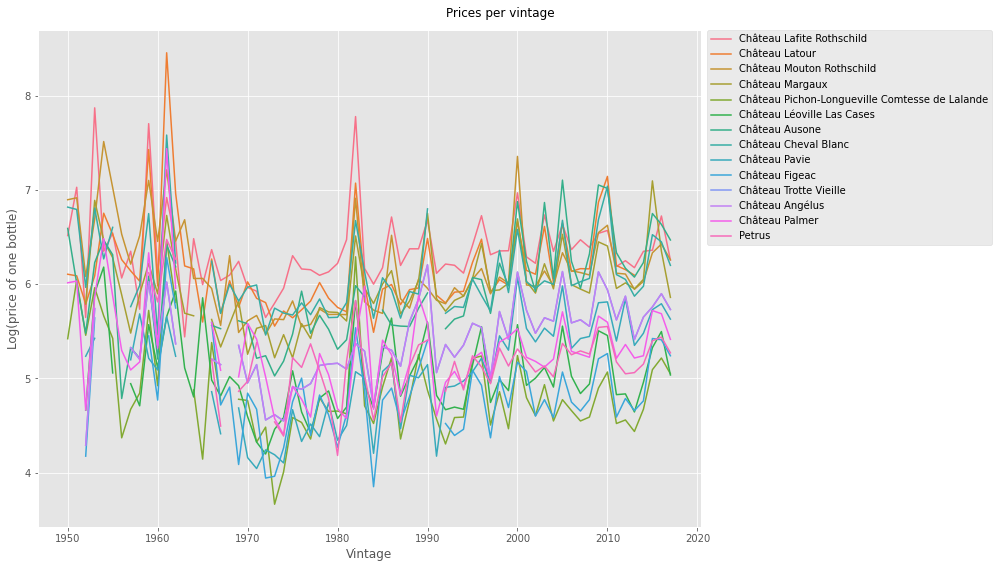

In [108]:
premiers = df[df['Chateau'].isin(top_wines)]
premiers.loc[:,'Log Price'] = np.log(premiers['Price'])
premiers.loc[:,'Vintage'] = premiers['Vintage'].astype(int)
premiers['Log price'] = np.log(premiers['Price'])
# Display premiers prices
plt.figure(figsize=(14,8))
sns.lineplot(data=premiers, x='Vintage', y='Log price', hue='Chateau')
plt.ylabel('Log(price of one bottle)')
plt.xlabel('Vintage')
plt.suptitle('Prices per vintage')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig('views/prices_per_vintage.png')
plt.show()


,Chateau,Vintage,Price,Price dec,Price may,Log Price,Price diff,Relative price diff,Abs relative price diff
0,Château Lafite Rothschild,1950,678.0,671.0,685.0,6.519147,7.0,0.010324,0.010324
1,Château Lafite Rothschild,1951,1133.0,1133.0,1133.0,7.032624,0.0,0.000000,0.000000
2,Château Lafite Rothschild,1952,284.0,284.0,284.0,5.648974,0.0,0.000000,0.000000
3,Château Lafite Rothschild,1953,2635.5,2666.0,2605.0,7.876828,-30.5,-0.011573,0.011573
4,Château Lafite Rothschild,1954,574.0,574.0,574.0,6.352629,0.0,0.000000,0.000000


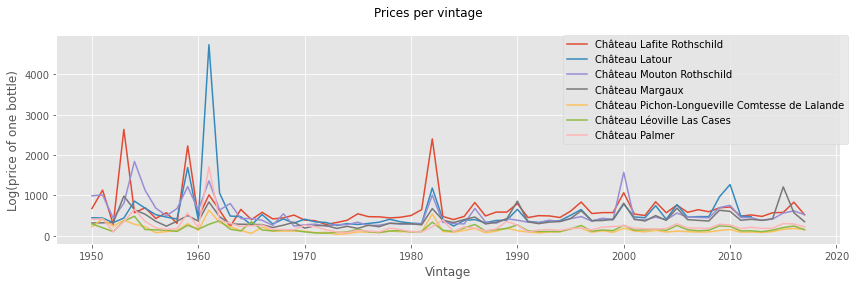

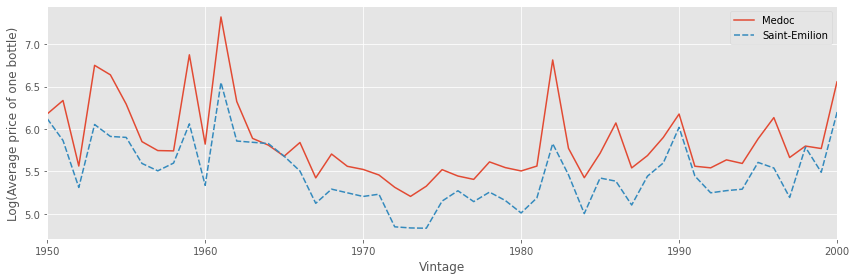

R2 between medoc and saint emilion: 0.448334090961953
R2 between medoc and saint emilion / log prices: 0.1786084171198986
Spearman between medoc and saint emilion: 0.7713043478260868
Spearman between medoc and saint emilion: 0.7713043478260868


In [112]:
medoc = df[df['Chateau'].isin(medoc_wines)]
st_em = df[df['Chateau'].isin(st_em_wines)]


# Interpolate missing values
medoc = medoc.interpolate()
st_em = st_em.interpolate()

# Delete post 2013 values for Latour
medoc.loc[(medoc['Chateau'] == 'Château Latour') & (medoc['Vintage'] >2012), 'Price'] = np.nan

# Display medoc prices
display(medoc.head())
sns.lineplot(data=medoc, x='Vintage', y='Price', hue='Chateau')
plt.ylabel('Log(price of one bottle)')
plt.xlabel('Vintage')
plt.suptitle('Prices per vintage')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.savefig('views/prices_per_vintage_medoc.png')
plt.show()

# NaNs are always ignored in Pandas aggregation functions
medoc = medoc[['Vintage', 'Chateau', 'Price']]
medoc = medoc.pivot(index = 'Vintage', columns = ['Chateau'])
medoc['Average price'] = medoc.mean(axis=1)

st_em = st_em[['Vintage', 'Chateau', 'Price']].interpolate()
st_em = st_em.pivot(index = 'Vintage', columns = ['Chateau'])
st_em['Average price'] = st_em.mean(axis=1)

medoc['Average price'].to_excel('data/prices/generated_average_prices_medoc.xlsx', index=True)
st_em['Average price'].to_excel('data/prices/generated_average_prices_st_em.xlsx', index=True)


prices = pd.concat((medoc['Average price'], st_em['Average price']), axis=1)
prices.columns = ['Medoc', 'Saint-Emilion']
sns.lineplot(data = np.log(prices))
plt.ylabel('Log(Average price of one bottle)')
plt.xlim((1950, 2000))
plt.tight_layout()

plt.savefig('views/st_em_VS_medoc.png')
plt.show()



avg_price_medoc = medoc['Average price'].loc[1994:2017]
avg_price_st_em = st_em['Average price'].loc[1994:2017]

print('R2 between medoc and saint emilion:', r2_score(avg_price_medoc, avg_price_st_em))
print('R2 between medoc and saint emilion / log prices:', r2_score(np.log(avg_price_medoc), np.log(avg_price_st_em)))

print('Spearman between medoc and saint emilion:', spearmanr(avg_price_medoc, avg_price_st_em)[0])
print('Spearman between medoc and saint emilion:', spearmanr(np.log(avg_price_medoc), np.log(avg_price_st_em))[0])

The wines of our sample have consistent variations.

Checker que les prix s'influencent pas trop entre eux (prix en primeurs fixés par le premier), voir si les critiques ont la meme correlation

In [47]:
average = premiers.groupby('Vintage')['Price'].mean().to_frame()

display(average.head())
average.reset_index().to_excel('data/prices/generated_average_prices.xlsx', index=False)

,Price
Vintage,
1950,469.071429
1951,676.000000
1952,219.692308
1953,640.250000
1954,725.000000


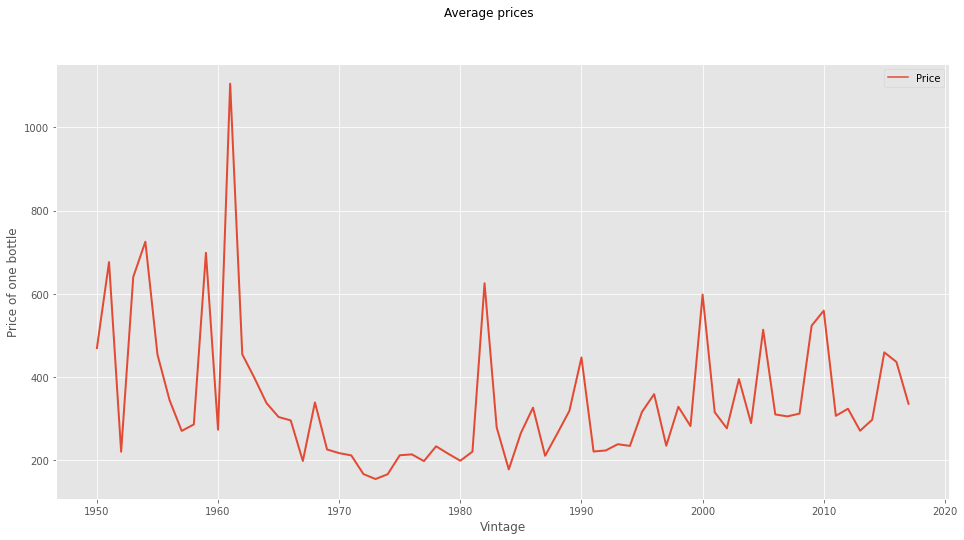

In [48]:
plt.figure(figsize=(16,8))
sns.lineplot(data=average, linewidth=2.0, color='black')

plt.ylabel('Price of one bottle')
plt.xlabel('Vintage')
plt.suptitle('Average prices')
plt.show()

# WA Ratings

In [49]:
ratings = pd.read_excel('data/ratings.xlsx')

#Select ratings up to 2017
ratings = ratings[ratings['Vintage'] <= 2017]

display(ratings.head())

,Chateau,Region,Vintage,Rating - LB,Rating - HB,Date,Critic
0,Château Lafite Rothschild,Médoc,1994,86.0,90.0,1995-04-01,Robert Parker
1,Château Lafite Rothschild,Médoc,1995,92.0,95.0,1996-04-01,Robert Parker
2,Château Lafite Rothschild,Médoc,1996,91.0,93.0,1997-04-01,Robert Parker
3,Château Lafite Rothschild,Médoc,1997,90.0,93.0,1998-04-01,Robert Parker
4,Château Lafite Rothschild,Médoc,1998,91.0,94.0,1999-04-01,Robert Parker


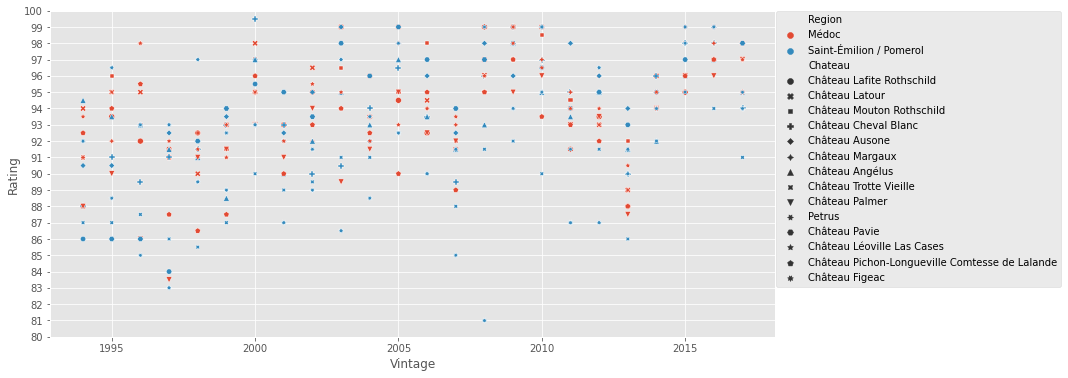

In [50]:
plt.figure(figsize=(13,6))
ratings['Rating'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
ratings = ratings[ratings['Chateau'].isin(top_wines)]
sns.scatterplot(data=ratings, x='Vintage', y='Rating',hue='Region', style='Chateau')
plt.legend(bbox_to_anchor=(1.001, 1),borderaxespad=0)
plt.ylim([80,100])
plt.yticks(range(80, 101))
plt.savefig('views/RP_ratings.png', bbox_inches='tight')

Montrer que Latour s'est barré des primeurs parce que sous noté en primeur

In [51]:
average_ratings = ratings.groupby('Vintage')['Rating'].mean().to_frame()
average_ratings.to_excel('data/generated_average_ratings.xlsx')

# RP Ratings vs Price

In [54]:
average_ratings = ratings.groupby('Vintage')['Rating'].mean().to_frame().loc[1994:2017]

average_price = average.loc[1994:2017]

print('Spearman correlation ratings-prices:', spearmanr(average_ratings, average_price)[0].round(2))
print('Spearman correlation ratings-prices, 1994 - 2005:', spearmanr(average_ratings.loc[1994:2005], average_price.loc[1994:2005])[0].round(2))
print('Spearman correlation ratings-prices, 2006 - 2017:', spearmanr(average_ratings.loc[2006:2017], average_price.loc[2006:2017])[0].round(2))

#print('R2 Score between ratings and prices:', r2_score(average_price, average_ratings))

Spearman correlation ratings-prices: 0.76
Spearman correlation ratings-prices, 1994 - 2005: 0.71
Spearman correlation ratings-prices, 2006 - 2017: 0.84


Series([], Name: Price, dtype: float64)
R2 between Médoc and Saint-Emilion ratings: 0.5116477498117566
Spearman between Médoc and Saint-Emilion ratings: 0.848564049012621

Spearman correlation ratings and prices for Médoc: 0.6549249991743813
Spearman correlation ratings and prices for Saint-Emilion: 0.8618666181598224


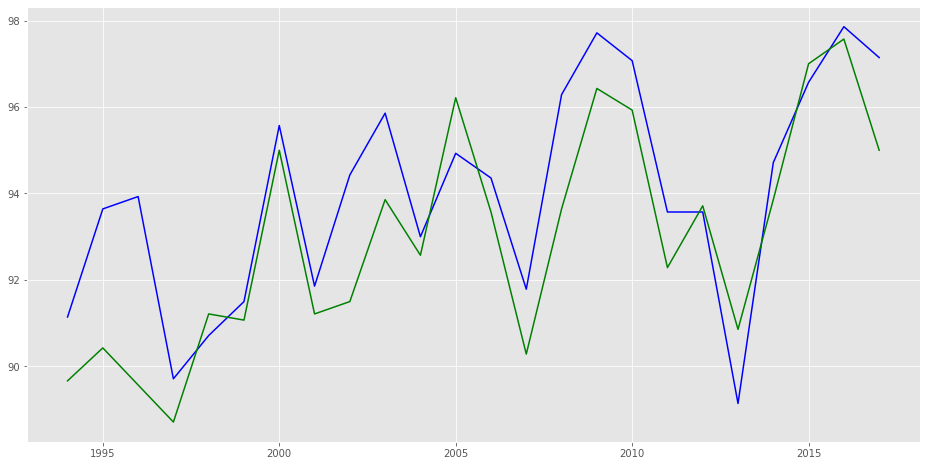

In [63]:
medoc = df[df['Chateau'].isin(['Château Lafite Rothschild', 'Château Mouton Rothschild', 'Château Latour', 'Château Margaux', 'Château Palmer', 'Château Léoville Las Cases', 'Château Pichon-Longueville Comtesse de Lalande'])]
st_emilion = df[df['Chateau'].isin(['Château Cheval Blanc', 'Château Ausone','Château Angélus', 'Château Trotte Vieille','Château Pavie', 'Petrus', 'Château Figeac'])]
avg_price_medoc = medoc.groupby('Vintage')['Price'].mean().loc[1950:2017].fillna(method='ffill')
avg_price_st_emilion = st_emilion.groupby('Vintage')['Price'].mean().loc[1950:2017].fillna(method='ffill')

rating_medoc = ratings[ratings['Chateau'].isin(['Château Lafite Rothschild', 'Château Mouton Rothschild', 'Château Latour', 'Château Margaux', 'Château Palmer', 'Château Léoville Las Cases', 'Château Pichon-Longueville Comtesse de Lalande'])]
rating_st_emilion = ratings[ratings['Chateau'].isin(['Château Cheval Blanc', 'Château Ausone','Château Angélus', 'Château Trotte Vieille','Château Pavie', 'Petrus', 'Château Figeac'])]
#print(rating_medoc)
avg_rating_medoc = rating_medoc.groupby('Vintage')['Rating'].mean().loc[1950:2017].fillna(method='ffill')
avg_rating_st_emilion = rating_st_emilion.groupby('Vintage')['Rating'].mean().loc[1950:2017].fillna(method='ffill')


plt.figure(figsize=(16,8))
plt.plot(avg_rating_medoc, color='blue')
plt.plot(avg_rating_st_emilion, color='green')
print(avg_price_st_emilion[avg_price_st_emilion.isnull()])

from sklearn.metrics import r2_score
from scipy.stats import spearmanr

print('R2 between Médoc and Saint-Emilion ratings:', r2_score(avg_rating_medoc, avg_rating_st_emilion))
print('Spearman between Médoc and Saint-Emilion ratings:', spearmanr(avg_rating_medoc, avg_rating_st_emilion)[0])

print('\nSpearman correlation ratings and prices for Médoc:', spearmanr(avg_rating_medoc.loc[1994:2017], avg_price_medoc.loc[1994:2017])[0])
print('Spearman correlation ratings and prices for Saint-Emilion:', spearmanr(avg_rating_st_emilion.loc[1994:2017], avg_price_st_emilion.loc[1994:2017])[0])

 Haut Brion increases Spearman correlation between ratings and prices for Medoc.